*08/19/24*
Authors: Ismael Mendoza

In [1]:
import jax 
import jax.numpy as jnp
from jax.scipy import stats

from jax import random
from jax import jit as jjit

In [2]:
import galsim 
import jax_galsim as xgalsim

2024-08-21 10:14:39.358899: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-08-21 10:15:13.959840: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import blackjax
import numpy as np 

import arviz as az
import chainconsumer as cc
import matplotlib.pyplot as plt

import numpyro
import time
from datetime import date

import matplotlib.pyplot as plt 

/pscratch/sd/i/imendoza/miniconda3/envs/bpd_gpu2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from tqdm import tqdm

In [5]:
from functools import partial

In [6]:
from blackjax.diagnostics import effective_sample_size, potential_scale_reduction

In [7]:
import bpd
from bpd.draw import add_noise
from bpd.measure import get_snr


In [8]:
from bpd.chains import inference_loop, inference_loop_multiple_chains

In [9]:
jax.devices()

[CudaDevice(id=0)]

In [10]:
GPU = jax.devices('gpu')[0]

In [11]:
jax.config.update("jax_enable_x64", True) # fair comparison with GalSim, among other reasons

# Drawing methods

In [51]:
# constant galaxy parameters to fit 
PIXEL_SCALE = 0.2
BACKGROUND = 1e4
SLEN= 53
PSF_HLR = 0.7

LOG_FLUX = 8.
HLR = 0.9
G1 = 0.05
G2 = 0.0
X=0.
Y=0.

TRUE_PARAMS = {'f': LOG_FLUX, 'hlr': HLR, 'g1': G1, 'g2': G2, 'x': X, 'y': Y}

In [52]:
def _draw_gal():
    gal = galsim.Gaussian(flux=10**LOG_FLUX, half_light_radius=HLR)
    gal = gal.shift(dx=X, dy=Y)
    gal = gal.shear(g1=G1, g2=G2)
    
    psf = galsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = galsim.Convolve([gal, psf])
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

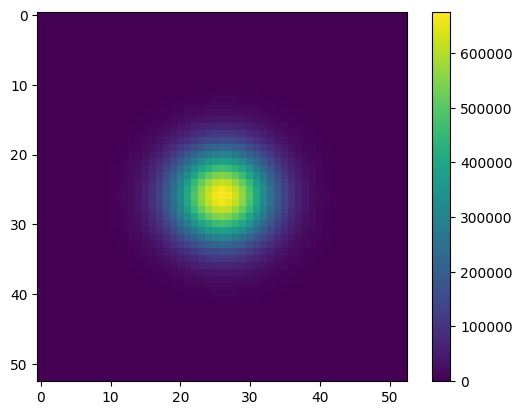

In [53]:
im_nn = _draw_gal()
im = add_noise(im_nn, BACKGROUND)[0] ## does not add background just noise
plt.imshow(im)
plt.colorbar()

In [54]:
print(get_snr(im_nn, BACKGROUND))

9682.09


In [55]:
from functools import partial
# jax drawing
GSPARAMS = xgalsim.GSParams(minimum_fft_size=256, maximum_fft_size=256)

def draw_gal(f, hlr, g1, g2, x, y):
    gal = xgalsim.Gaussian(flux=10**f, half_light_radius=hlr)
    gal = gal.shift(dx=x, dy=y)
    gal = gal.shear(g1=g1, g2=g2)
    
    psf = xgalsim.Gaussian(flux=1., half_light_radius=PSF_HLR)
    gal_conv = xgalsim.Convolve([gal, psf]).withGSParams(GSPARAMS)
    image = gal_conv.drawImage(nx=SLEN,ny=SLEN,scale=PIXEL_SCALE,
                                 )
    return image.array

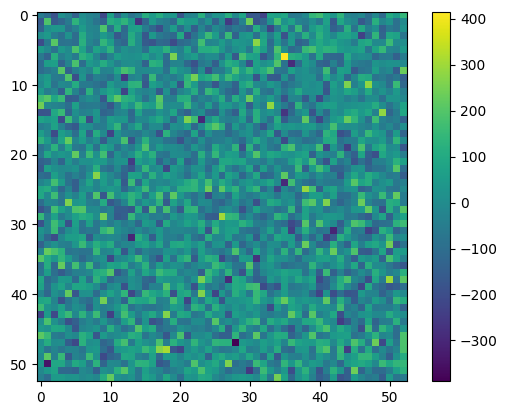

In [56]:
# sanity check 1
res = im - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

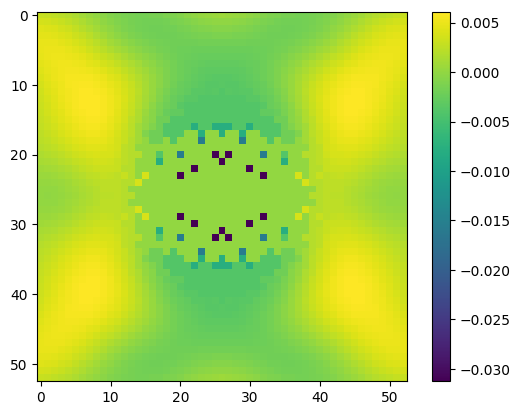

In [57]:
# sanity check 2
res = im_nn - draw_gal(**TRUE_PARAMS)
plt.imshow(res)
plt.colorbar()

In [58]:
# # timing makes sense
# draw_gal_jitted = jax.jit(draw_gal)
# draw_gal_jitted(**TRUE_PARAMS)

# %timeit draw_gal_jitted(**TRUE_PARAMS) # ~ twice fast
# %timeit _draw_gal()

196 μs ± 3.76 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
463 μs ± 11.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


# Setup logprob

In [59]:
TRUE_PARAMS_GPU = jax.device_put(TRUE_PARAMS, device=GPU)
BACKGROUND_GPU = jax.device_put(BACKGROUND, device=GPU)
BOUNDS = {'f': (0., 9.), 'hlr': (0.01, 5.0), 'g1': (-0.6, 0.6), 'g2': (-0.6, 0.6), 
          'x': (-0.5 * PIXEL_SCALE, 0.5 * PIXEL_SCALE), 'y':(-0.5 * PIXEL_SCALE, 0.5 * PIXEL_SCALE)
}
BOUNDS_GPU = jax.device_put(BOUNDS, device=GPU)

In [60]:
def transform_func(params):
    """Every variable is assumed to be uniform between (0,1)"""
    new = {} 
    for p in params:
        new[p] = params[p] * (BOUNDS_GPU[p][1] - BOUNDS_GPU[p][0]) + BOUNDS_GPU[p][0]
    return new

def inv_transform_func(params):
    """Maps variables to (0, 1)"""
    new = {} 
    for p in params:
        new[p] = (params[p] - BOUNDS_GPU[p][0]) / (BOUNDS_GPU[p][1] - BOUNDS_GPU[p][0]) 
    return new

def _logprob_fn(params, data):    
    #prior
    prior = jax.device_put(0.,device=GPU) 
    for p in params:
        b1, b2 = BOUNDS_GPU[p]
        prior += stats.uniform.logpdf(params[p], b1, b2-b1)

    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)

def _logprob_fn_transform(std_params, data):
    params = transform_func(std_params)
    
    #prior
    prior = jax.device_put(0.,device=GPU) 
    for p in params:
        prior += stats.uniform.logpdf(std_params[p], 0, 1)

             
    # likelihood
    model = draw_gal(**params)
    likelihood = stats.norm.logpdf(data, loc=model, scale=jnp.sqrt(BACKGROUND_GPU))
    
    return jnp.sum(prior) + jnp.sum(likelihood)

# Blackjax NUTS

In [61]:
from bpd.chains import inference_loop, inference_loop_multiple_chains

## Warmup and divergences

In [97]:
SEED = 42
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED), 
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)
{CudaDevice(id=0)}


In [98]:
logdensity = jjit(partial(_logprob_fn, data=data_gpu), backend='gpu')
_ = logdensity(TRUE_PARAMS_GPU) # executre compilation

In [99]:
_, warmup_key, sample_key = jax.random.split(rng_key, 3)

In [100]:
warmup = blackjax.window_adaptation(
    blackjax.nuts, logdensity, progress_bar=False, is_mass_matrix_diagonal=True
)

In [101]:
init_positions = {**TRUE_PARAMS_GPU}

In [105]:
%%time
(init_states, tuned_params), adapt_info = warmup.run(warmup_key, init_positions, 500) # rerunnig takes half time??

CPU times: user 4.5 s, sys: 987 μs, total: 4.5 s
Wall time: 4.49 s


In [106]:
tuned_params

{'step_size': Array(0.00127085, dtype=float64, weak_type=True),
 'inverse_mass_matrix': Array([2.43903641e-05, 2.43911274e-05, 2.43909593e-05, 2.43908313e-05,
        2.43907350e-05, 2.43908151e-05], dtype=float64)}

In [107]:
# DIVERGENCES
adapt_info.info.is_divergent.sum()

Array(25, dtype=int64)

(array([ 40.,   5.,   5.,   2.,   4.,   8.,   8.,   2.,   4.,   2.,   4.,
          2.,   9.,   4.,   7.,   6.,   7.,   7.,   8.,  16.,  12.,  20.,
         35.,  50., 233.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ]),
 <BarContainer object of 25 artists>)

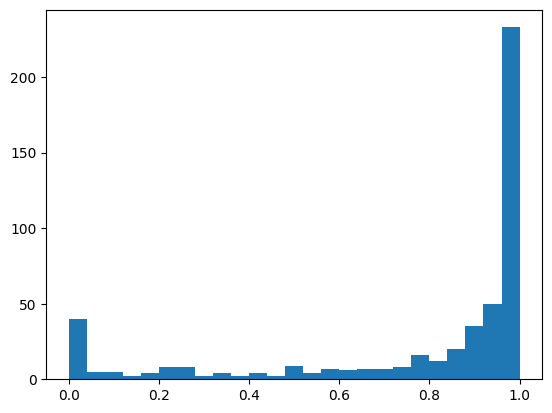

In [108]:
plt.hist(adapt_info.info.acceptance_rate, bins=25)

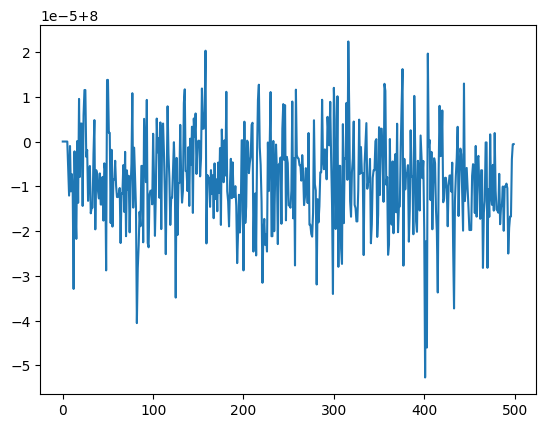

In [109]:
plt.plot(adapt_info.state.position['f'])

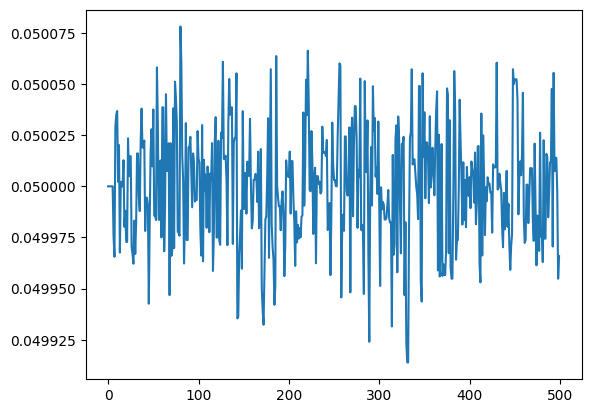

In [110]:
plt.plot(adapt_info.state.position['g1'])

## Run multiple chains (same tuning)

In [111]:
# `tuned_params` and `data_gpu` from above

In [171]:
nuts = blackjax.mcmc.nuts.as_top_level_api(logdensity, **tuned_params, max_num_doublings=10)

In [172]:
N_CHAINS = 100
initial_positions = {p:q*jnp.ones((N_CHAINS,)) for p,q in TRUE_PARAMS_GPU.items()}
initial_states = jax.vmap(nuts.init, in_axes=(0))(initial_positions)

In [173]:
%%time
### really fast even with n_chains large
states, infos = inference_loop_multiple_chains(
    sample_key, nuts.step, initial_states, n_samples=200, n_chains=N_CHAINS
)
_ = states.position["f"].block_until_ready()

CPU times: user 18.9 s, sys: 165 ms, total: 19.1 s
Wall time: 18.1 s


In [174]:
samples = states.position

In [175]:
samples['f'].shape

(200, 100)

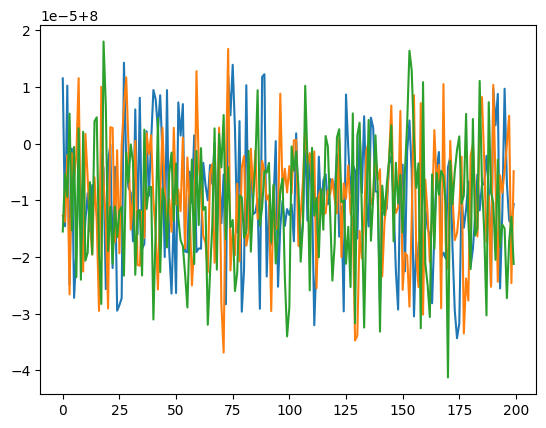

In [176]:
plt.plot(samples['f'][:, 0])
plt.plot(samples['f'][:, 5])
plt.plot(samples['f'][:, 8])

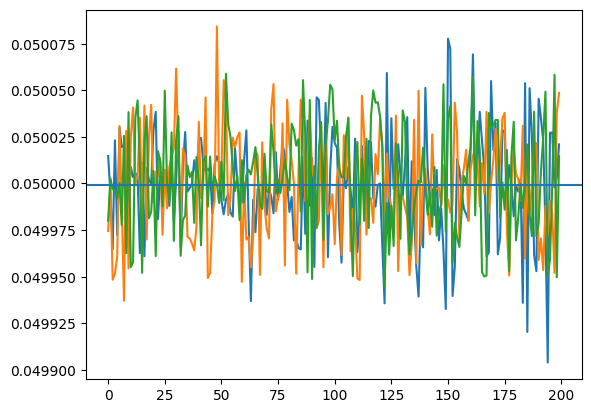

In [177]:
plt.plot(samples['g1'][:, 0])
plt.plot(samples['g1'][:, 5])
plt.plot(samples['g1'][:, 8])
plt.axhline(samples['g1'].mean())

### ESS

In [178]:
# ess
print('ess')
print()
for p in samples: 
    ess = effective_sample_size(samples[p], chain_axis=1 ,sample_axis=0)
    print(p, ess)
    print('rel: %', ess * 100 / samples[p].size)
    print()
    
print()
print('r-hat')
print()
for p in samples: 
    print(p, potential_scale_reduction(samples[p], chain_axis=1 ,sample_axis=0))


ess

f 22936.6606144779
rel: % 114.68330307238949

g1 20510.758184006896
rel: % 102.55379092003449

g2 20277.583867706024
rel: % 101.38791933853011

hlr 22115.90882410934
rel: % 110.57954412054671

x 27768.707840136667
rel: % 138.84353920068332

y 26684.237846930777
rel: % 133.4211892346539


r-hat

f 0.9998862353486402
g1 1.0000859408668576
g2 1.0003217160617937
hlr 1.0000534626695003
x 0.9995208004590739
y 0.9993600846432873


In [182]:
az.ess(np.array(samples['g1'].T))

20760.64461625803

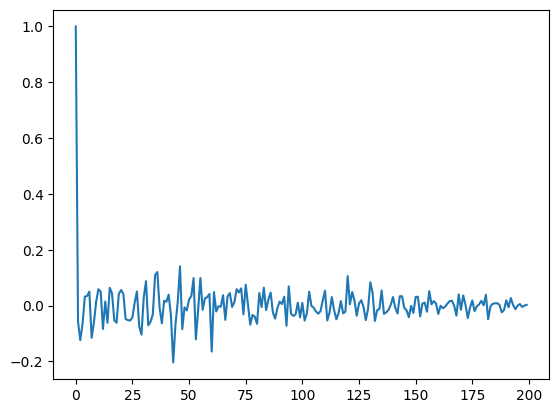

In [181]:
acr = az.autocorr(samples['g1'][:, 0])
plt.plot(acr)

### Contours

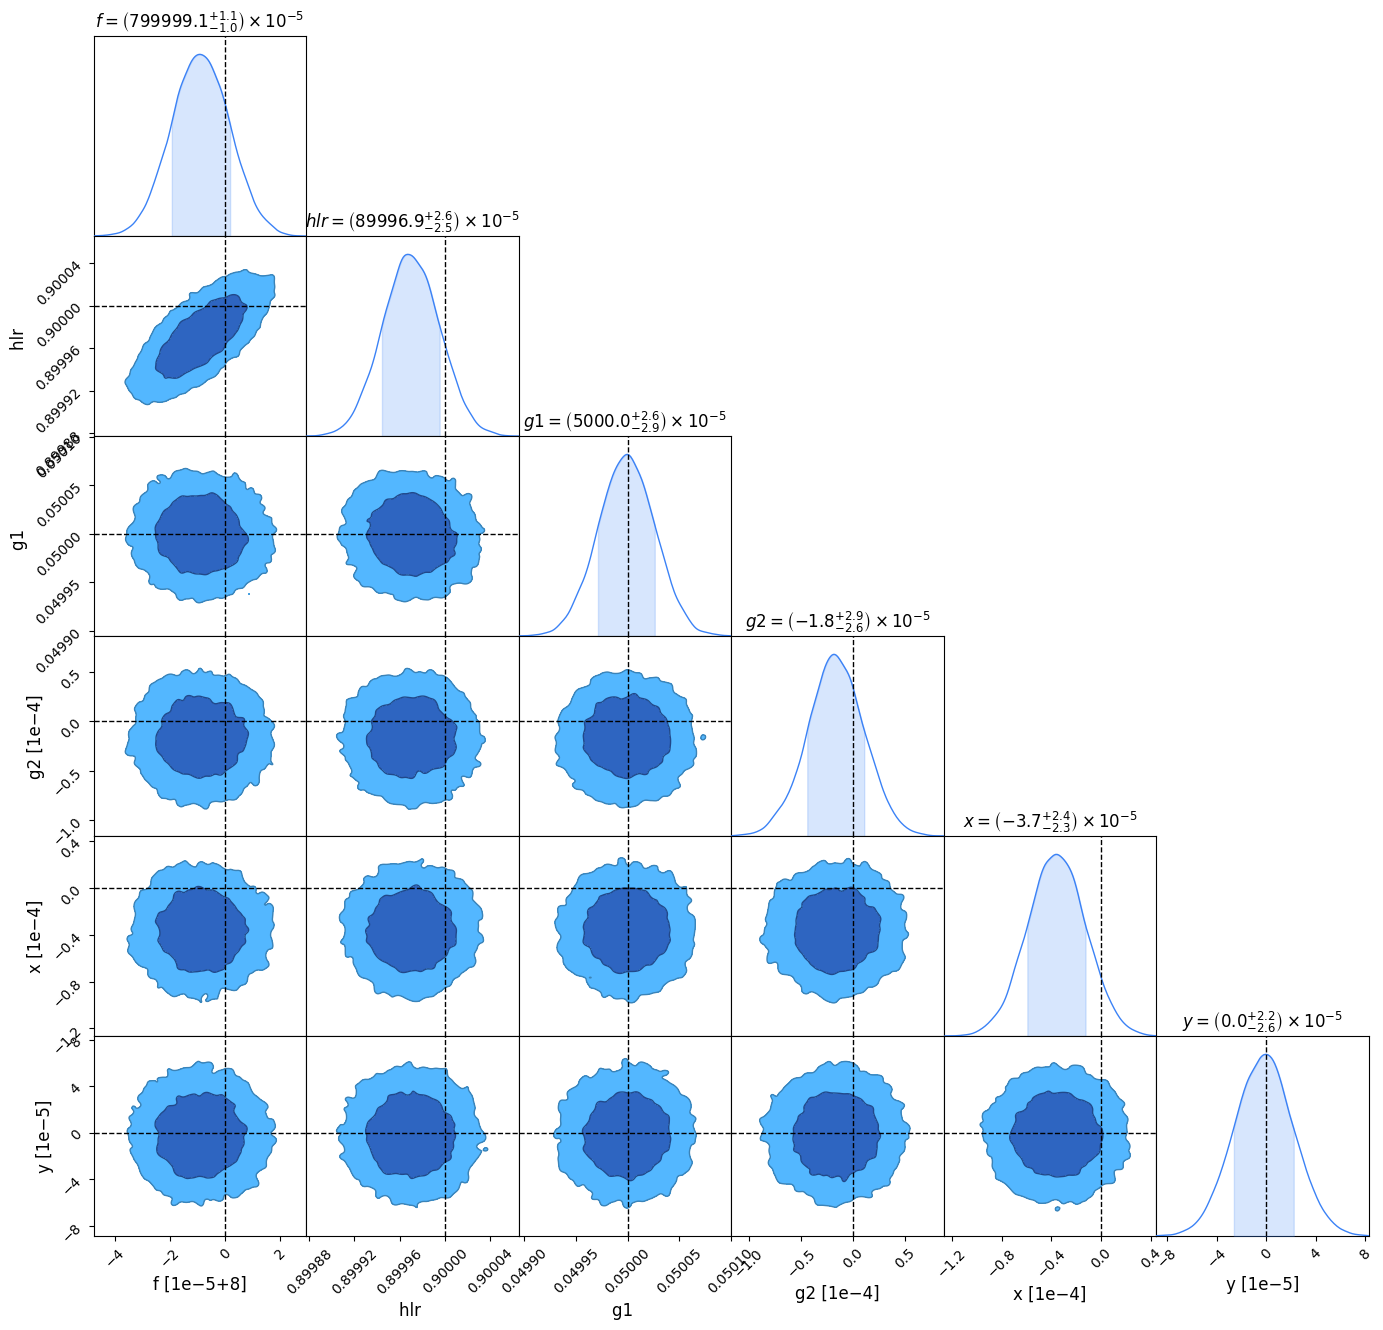

In [183]:
# example of corner plots
from chainconsumer import ChainConsumer, Truth, Chain
import pandas as pd
c = ChainConsumer()
_samples = {k:samples[k].reshape(-1) for k in ['f', 'hlr', 'g1', 'g2', 'x', 'y']}
df =pd.DataFrame.from_dict(_samples)
c.add_chain(
    Chain(samples=df,
    name='Posterior')
)
c.add_truth(Truth(location=TRUE_PARAMS))
fig = c.plotter.plot()

# Blackjax Barker

In [184]:
from blackjax.adaptation.step_size import find_reasonable_step_size

## Warmup and acceptance rate

In [185]:
#data 
SEED = 53
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED),
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

#key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)
{CudaDevice(id=0)}


In [186]:
_, warmup_key, sample_key  = random.split(rng_key, 3)

In [187]:
init_positions = {**TRUE_PARAMS_GPU}

In [188]:
logdensity = jjit(partial(_logprob_fn, data=data_gpu) )

In [189]:
INIT_STEP_SIZE = 1.
init_kernel = blackjax.barker.as_top_level_api(logdensity, step_size=INIT_STEP_SIZE)
init_state=init_kernel.init(init_positions)

In [190]:
def kernel_generator(step_size):
    return blackjax.barker.as_top_level_api(logdensity, step_size=step_size).step

In [191]:
%%time
tuned_step_size =find_reasonable_step_size(warmup_key, kernel_generator, reference_state=init_state, 
                                           target_accept=0.8, initial_step_size=INIT_STEP_SIZE)
tuned_step_size

CPU times: user 2.32 s, sys: 88.8 ms, total: 2.41 s
Wall time: 2.44 s


Array(1.52587891e-05, dtype=float64, weak_type=True)

In [192]:
%%time
states, info = inference_loop(sample_key, kernel_generator(tuned_step_size), init_state, n_samples=1000)

CPU times: user 2.64 s, sys: 50.9 ms, total: 2.69 s
Wall time: 2.69 s


(array([146.,  29.,  40.,  20.,  30.,  24.,  17.,  22.,  15.,  14.,  19.,
         16.,  22.,  19.,  17.,  16.,  26.,  23.,  24.,  19.,  20.,  21.,
         28.,  33., 340.]),
 array([3.1738834e-16, 4.0000000e-02, 8.0000000e-02, 1.2000000e-01,
        1.6000000e-01, 2.0000000e-01, 2.4000000e-01, 2.8000000e-01,
        3.2000000e-01, 3.6000000e-01, 4.0000000e-01, 4.4000000e-01,
        4.8000000e-01, 5.2000000e-01, 5.6000000e-01, 6.0000000e-01,
        6.4000000e-01, 6.8000000e-01, 7.2000000e-01, 7.6000000e-01,
        8.0000000e-01, 8.4000000e-01, 8.8000000e-01, 9.2000000e-01,
        9.6000000e-01, 1.0000000e+00]),
 [<matplotlib.patches.Polygon at 0x7f24c06b2dd0>])

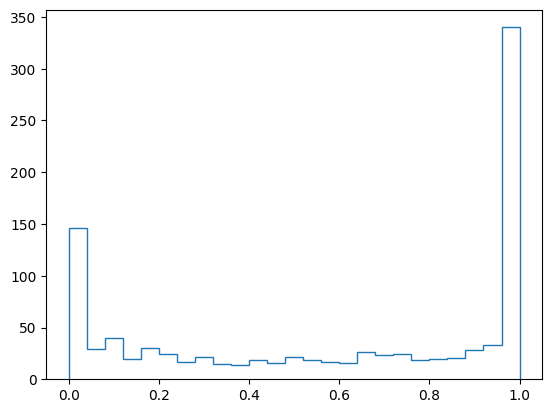

In [193]:
plt.hist(info.acceptance_rate, histtype='step', bins=25)

In [194]:
samples = states.position

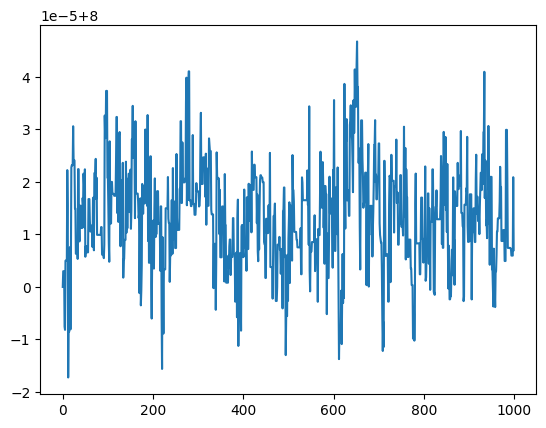

In [195]:
plt.plot(samples['f'])

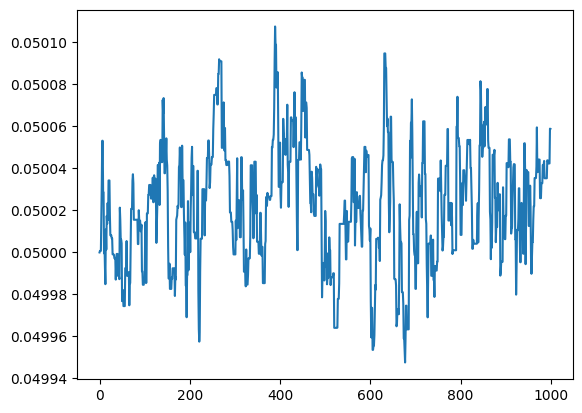

In [196]:
plt.plot(samples['g1'])

## Run multiple barker chains simultaneously with same parameters and 1 image

In [233]:
from bpd.chains import inference_loop_multiple_chains

In [234]:
N_CHAINS=100

In [235]:
#data 
SEED = 42
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED),
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

#key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)
{CudaDevice(id=0)}


In [236]:
logdensity = jjit(partial(_logprob_fn, data=data_gpu) )

In [237]:
barker = blackjax.barker.as_top_level_api(logdensity, step_size=3e-5)
kernel = jjit(barker.step)

In [238]:
init_positions = {p:q*jnp.ones((N_CHAINS,)) for p,q in TRUE_PARAMS_GPU.items()}
init_positions['f'].shape

(100,)

In [239]:
init_states = jax.vmap(barker.init)(init_positions)

In [240]:
%%time
states, infos = inference_loop_multiple_chains(rng_key, kernel, init_states, 1000, N_CHAINS)

CPU times: user 8.56 s, sys: 105 ms, total: 8.67 s
Wall time: 7.96 s


In [241]:
samples = states.position
samples['f'].shape

(1000, 100)

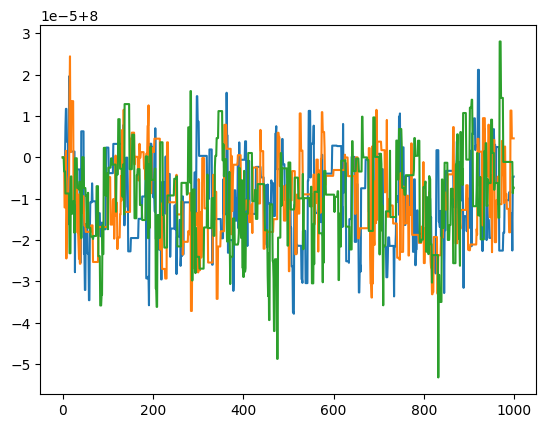

In [242]:
plt.plot(samples['f'][:, 0])
plt.plot(samples['f'][:, 5])
plt.plot(samples['f'][:, 21])

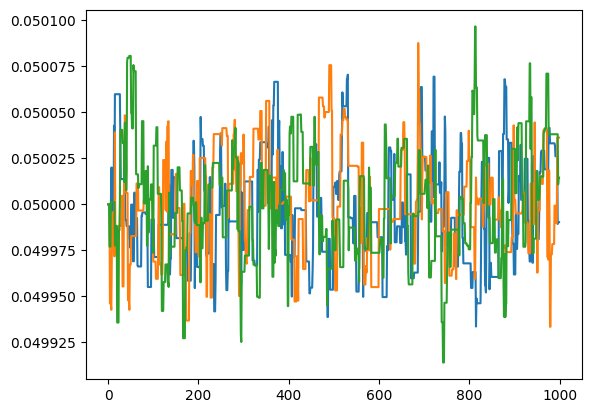

In [243]:
plt.plot(samples['g1'][:, 0])
plt.plot(samples['g1'][:, 5])
plt.plot(samples['g1'][:, 21])

### Contours

In [244]:
samples['f'].shape

(1000, 100)

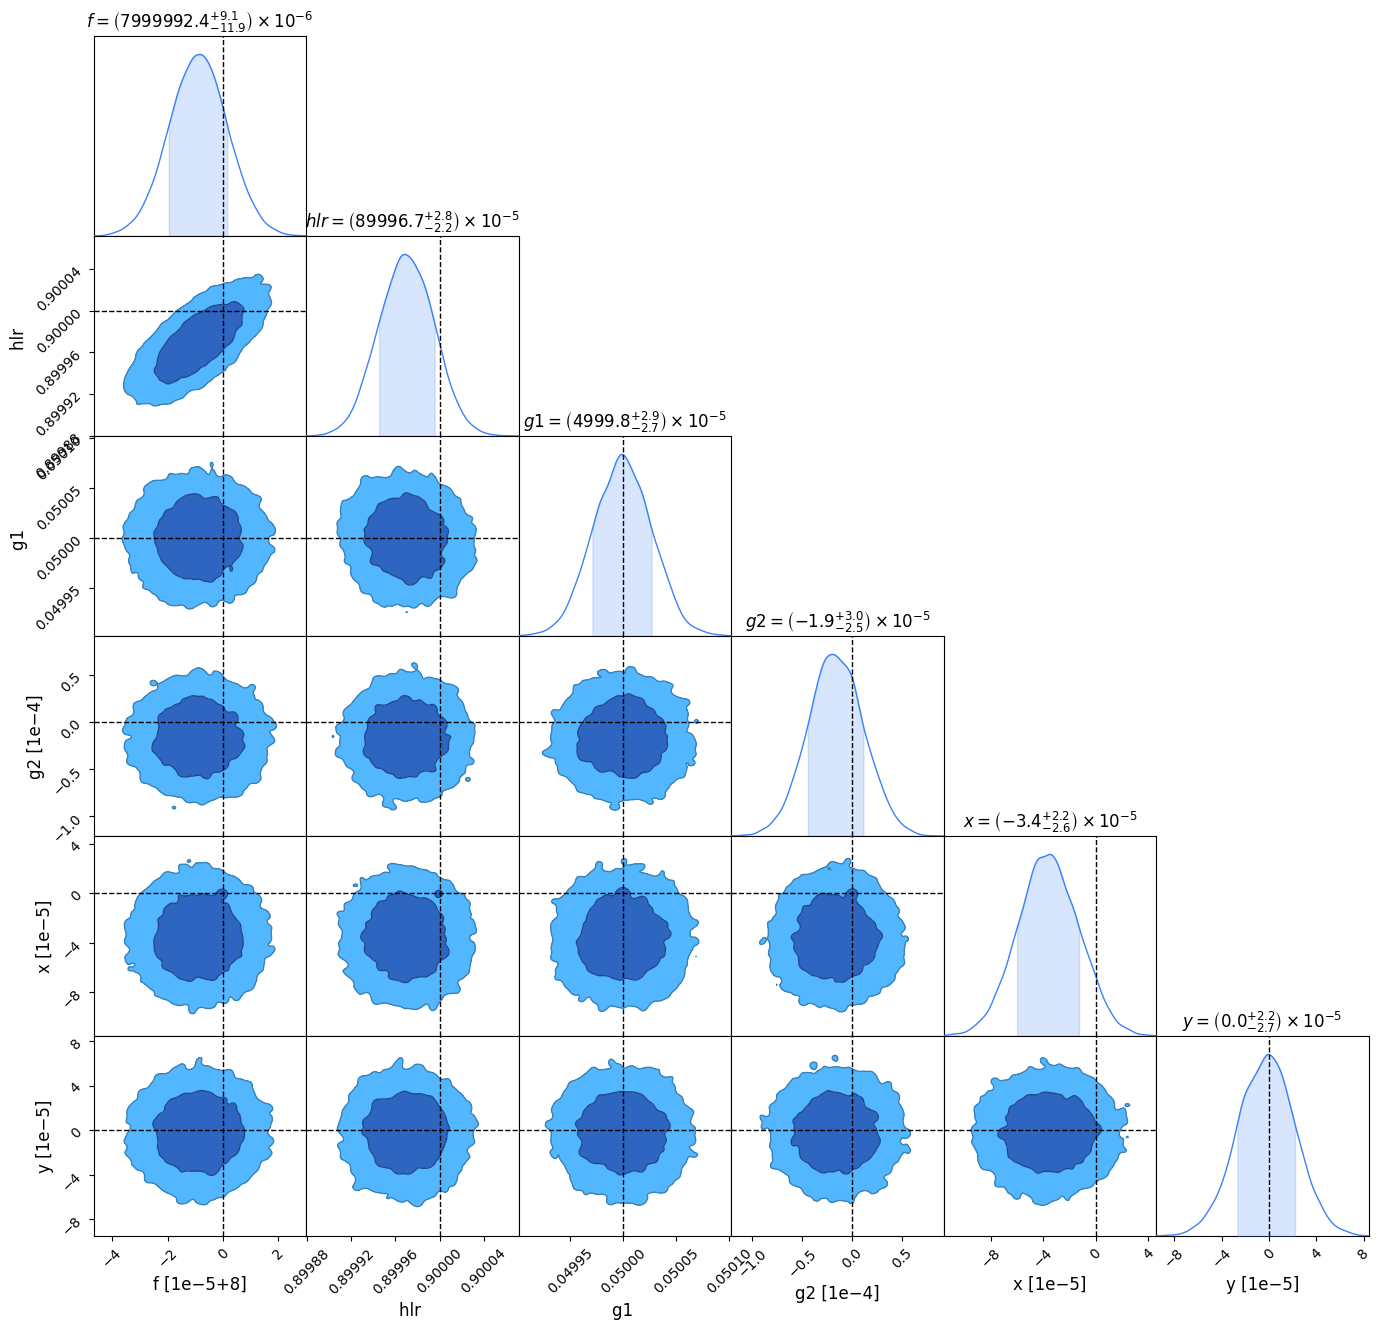

In [247]:
# example of corner plots
from chainconsumer import ChainConsumer, Truth, Chain
import pandas as pd
c = ChainConsumer()
_samples = {k:samples[k].reshape(-1) for k in ['f', 'hlr', 'g1', 'g2', 'x', 'y']}
df =pd.DataFrame.from_dict(_samples)
c.add_chain(
    Chain(samples=df,
    name='Posterior')
)
c.add_truth(Truth(location=TRUE_PARAMS))
fig = c.plotter.plot()

### ESS and autocorr

In [248]:
samples['f'].shape

(1000, 100)

In [249]:
# ess
print('ess')
print()
for p in samples: 
    ess = effective_sample_size(samples[p], chain_axis=1 ,sample_axis=0)
    print(p, ess)
    print('rel: %', ess * 100 / samples[p].size)
    print()
    
print()
print('r-hat')
print()
for p in samples: 
    print(p, potential_scale_reduction(samples[p], chain_axis=1 ,sample_axis=0))


ess

f 7077.970695096934
rel: % 7.077970695096934

g1 6592.876880262109
rel: % 6.592876880262109

g2 7078.356747454647
rel: % 7.078356747454647

hlr 5637.890607417702
rel: % 5.6378906074177015

x 8421.742228505333
rel: % 8.421742228505332

y 7405.098025636866
rel: % 7.405098025636867


r-hat

f 1.0060206929309456
g1 1.0066464459666633
g2 1.0058279839933002
hlr 1.007868626166831
x 1.0050671643149762
y 1.0054128397442965


In [250]:
az.ess(np.array(samples['f'].T)) # close enough to arviz

7090.131282799011

In [251]:
aucorr = az.autocorr(np.array(samples['f'][:, 1]))
aucorr.shape

(1000,)

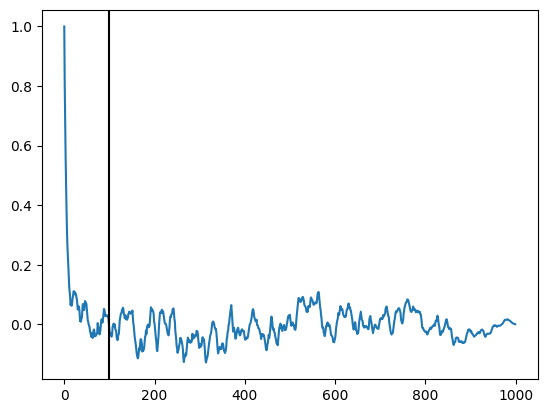

In [252]:
plt.plot(aucorr)
plt.axvline(100, color='k')

## Run on different data in parallel

In [50]:
from bpd.chains import inference_loop_multiple_chains_with_data

In [51]:
N_CHAINS=100

In [52]:
#data 
SEED = 42
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED),
                 n=N_CHAINS)
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

#key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (100, 53, 53)
{CudaDevice(id=0)}


In [53]:
init_positions = {p:q*jnp.ones((N_CHAINS,)) for p,q in TRUE_PARAMS_GPU.items()}
init_positions['f'].shape

(100,)

In [54]:
%%time
STEP_SIZE = 0.03125
def get_init_state(data, init_pos):
    _logdensity = partial(_logprob_fn, data=data)
    barker = blackjax.barker.as_top_level_api(_logdensity, step_size=STEP_SIZE)
    return barker.init(init_pos)

init_states = jax.vmap(get_init_state)(data_gpu, init_positions)

CPU times: user 525 ms, sys: 0 ns, total: 525 ms
Wall time: 484 ms


In [55]:
barker_params = jax.device_put({'step_size': STEP_SIZE * jnp.ones((N_CHAINS,))}, device=GPU)
barker_params['step_size'].devices()

{CudaDevice(id=0)}

In [56]:
%%time
states, infos = inference_loop_multiple_chains_with_data(rng_key, init_states, barker_params, data_gpu, 
                                         blackjax.barker.build_kernel(),
                                         _logprob_fn, 
                                         n_samples=5000, 
                                         n_chains = N_CHAINS
                                        )

CPU times: user 19.7 s, sys: 59.8 ms, total: 19.7 s
Wall time: 18.7 s


In [57]:
samples = states.position

In [58]:
samples['f'].shape

(5000, 100)

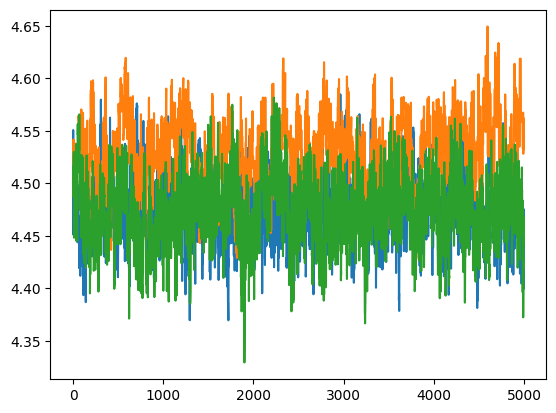

In [61]:
plt.plot(samples['f'][:, 0])
plt.plot(samples['f'][:, 10])
plt.plot(samples['f'][:, 21])

## Try Barker with parameter normalization

In [190]:
#data 
SEED = 54
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED),
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

#key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)
{CudaDevice(id=0)}


In [191]:
_, warmup_key, sample_key  = random.split(rng_key, 3)

In [192]:
logdensity = jjit(partial(_logprob_fn_transform, data=data_gpu) )

In [193]:
init_positions = inv_transform_func(TRUE_PARAMS_GPU)
init_positions, transform_func(init_positions)

({'f': Array(0.5, dtype=float64, weak_type=True),
  'g1': Array(0.75, dtype=float64, weak_type=True),
  'g2': Array(0.5, dtype=float64, weak_type=True),
  'hlr': Array(0.4, dtype=float64, weak_type=True)},
 {'f': Array(4.5, dtype=float64, weak_type=True),
  'g1': Array(0.05, dtype=float64, weak_type=True),
  'g2': Array(0., dtype=float64, weak_type=True),
  'hlr': Array(0.9, dtype=float64, weak_type=True)})

In [221]:
STEP_SIZE = 0.05
barker = blackjax.barker.as_top_level_api(logdensity, step_size=STEP_SIZE)
kernel = barker.step
init_state=barker.init(init_positions)

In [222]:
%%time
states, info = inference_loop(sample_key, kernel, init_state, n_samples=10000)

CPU times: user 5.67 s, sys: 75.8 ms, total: 5.74 s
Wall time: 6 s


(array([1925.,  299.,  235.,  189.,  149.,  160.,  167.,  134.,  126.,
         128.,  135.,  105.,  123.,  107.,  120.,  138.,  137.,  126.,
         151.,  168.,  184.,  215.,  240.,  353., 4186.]),
 array([0.  , 0.04, 0.08, 0.12, 0.16, 0.2 , 0.24, 0.28, 0.32, 0.36, 0.4 ,
        0.44, 0.48, 0.52, 0.56, 0.6 , 0.64, 0.68, 0.72, 0.76, 0.8 , 0.84,
        0.88, 0.92, 0.96, 1.  ]),
 [<matplotlib.patches.Polygon at 0x7f6fc4b801c0>])

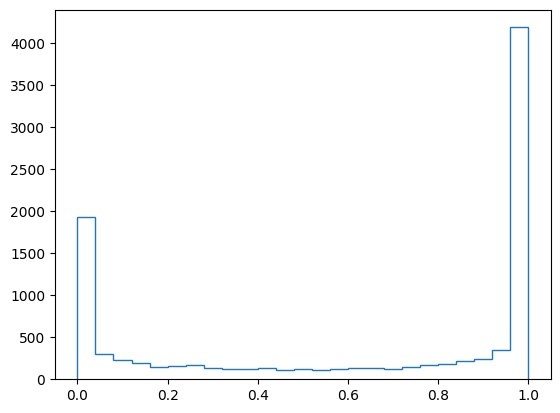

In [223]:
plt.hist(info.acceptance_rate, histtype='step', bins=25)

In [224]:
samples = states.position

In [225]:
init_positions

{'f': Array(0.5, dtype=float64, weak_type=True),
 'g1': Array(0.75, dtype=float64, weak_type=True),
 'g2': Array(0.5, dtype=float64, weak_type=True),
 'hlr': Array(0.4, dtype=float64, weak_type=True)}

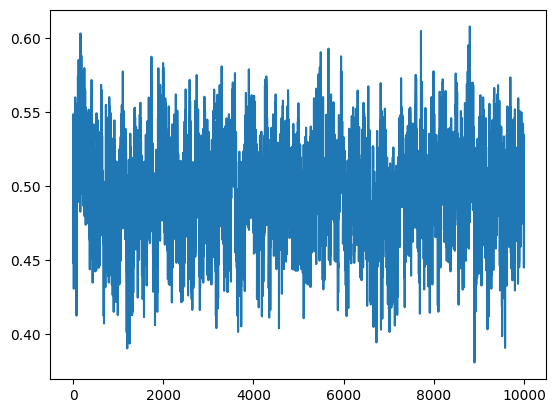

In [226]:
plt.plot(samples['f'])

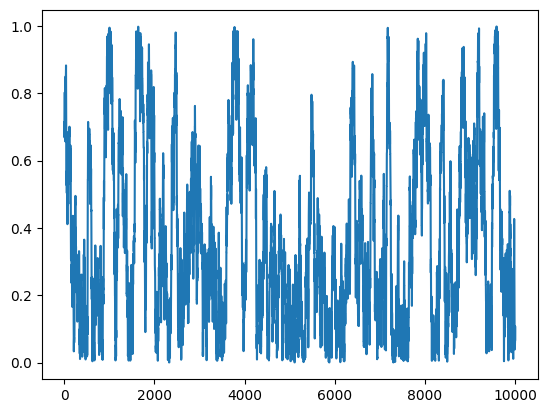

In [227]:
plt.plot(samples['g1'])

### Run multiple chains with this step size

In [318]:
#data 
SEED = 55
data = add_noise(_draw_gal(), BACKGROUND, 
                 rng=np.random.default_rng(SEED),
                 n=1)[0]
data_gpu = jax.device_put(data, device=GPU)
print(data_gpu.devices(), type(data_gpu), data_gpu.shape)

#key
rng_key = jax.random.key(SEED)
rng_key = jax.device_put(rng_key, device=GPU)
print(rng_key.devices())

{CudaDevice(id=0)} <class 'jaxlib.xla_extension.ArrayImpl'> (53, 53)
{CudaDevice(id=0)}


In [319]:
N_CHAINS = 100

In [320]:
_, sample_key  = random.split(rng_key, 2)

In [321]:
logdensity = jjit(partial(_logprob_fn_transform, data=data_gpu) )

In [322]:
STEP_SIZE = 0.075
barker = blackjax.barker.as_top_level_api(logdensity, step_size=STEP_SIZE)
kernel = barker.step

In [323]:
_init_positions = inv_transform_func(TRUE_PARAMS_GPU)
init_positions = {p:q*jnp.ones((N_CHAINS,)) for p,q in _init_positions.items()}
init_positions['f'].shape, init_positions['f'].devices()

((100,), {CudaDevice(id=0)})

In [324]:
init_states = jax.vmap(barker.init)(init_positions)

In [325]:
%%time
states, infos = inference_loop_multiple_chains(rng_key, kernel, init_states, 1000, N_CHAINS)
_ = states.position['f'].block_until_ready()

CPU times: user 7.95 s, sys: 133 ms, total: 8.08 s
Wall time: 6.35 s


In [326]:
samples = states.position

In [327]:
samples['f'].shape

(1000, 100)

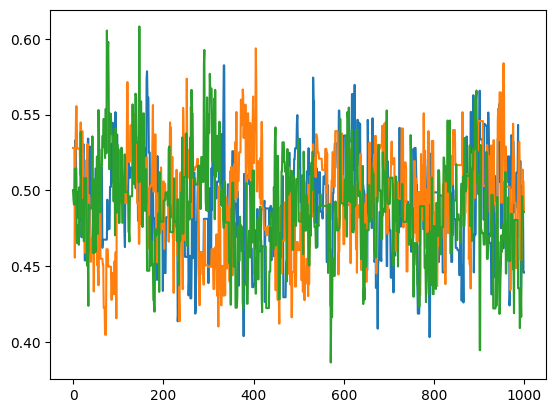

In [328]:
plt.plot(samples['f'][:, 0])
plt.plot(samples['f'][:, 5])
plt.plot(samples['f'][:, 21])

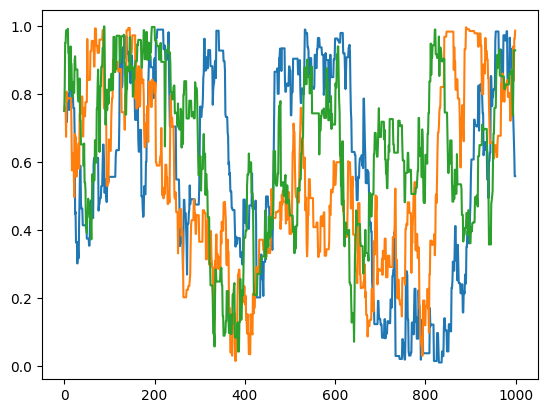

In [329]:
plt.plot(samples['g1'][:, 0])
plt.plot(samples['g1'][:, 5])
plt.plot(samples['g1'][:, 21])

### ESS

In [330]:
samples['f'].shape

(1000, 100)

In [331]:
# ess
print('ess')
print()
for p in samples: 
    ess = effective_sample_size(samples[p], chain_axis=1 ,sample_axis=0)
    print(p, ess)
    print('rel: %', ess * 100 / samples[p].size)
    print()
    
print()
print('r-hat')
print()
for p in samples: 
    print(p, potential_scale_reduction(samples[p], chain_axis=1 ,sample_axis=0))


ess

f 4911.674755071362
rel: % 4.9116747550713615

g1 950.5696144167497
rel: % 0.9505696144167497

g2 592.1672745689967
rel: % 0.5921672745689968

hlr 2806.874118349242
rel: % 2.806874118349242


r-hat

f 1.0084110009516978
g1 1.0467961521068794
g2 1.064645250366202
hlr 1.0175062786071665


In [332]:
az.ess(np.array(samples['f'].T)) # close enough to arviz

5004.148716612686

In [335]:
aucorr = az.autocorr(np.array(samples['g1'][:, 1]))
aucorr.shape

(1000,)

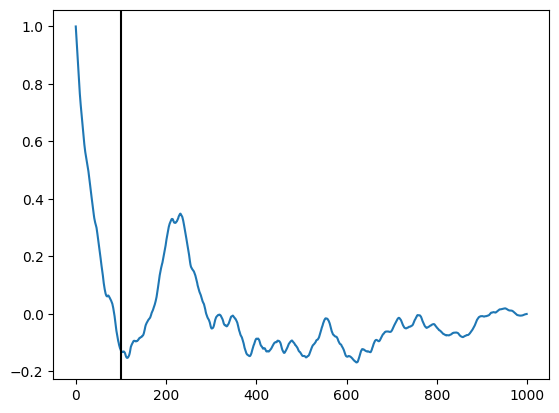

In [336]:
plt.plot(aucorr)
plt.axvline(100, color='k')